In [53]:
import pandas as pd

# Charger fichiers CSV
PBC_APL_ML_1 = pd.read_csv("PBC_APL_all_features_noyau_1_2.csv")


# Nettoyage des données

In [54]:
# Drop des colonnes et classes non nécessaires
cols_to_drop = ["Nom", "Numéro", "Chemin image", "dataset", "Boîte encadrante", "Centre"]
PBC_APL_ML_1 = PBC_APL_ML_1.drop(columns=cols_to_drop)
PBC_APL_ML_1 = PBC_APL_ML_1[~PBC_APL_ML_1['Classe'].isin(['giant thrombocyte','lymphocyte, variant','plasma cells','promonocyte'])]

In [55]:
# Suppression des valeurs aberrantes
numerical_features = PBC_APL_ML_1.select_dtypes(include=['float64', 'int64']).columns
Q1 = PBC_APL_ML_1[numerical_features].quantile(0.25)
Q3 = PBC_APL_ML_1[numerical_features].quantile(0.75)
IQR = Q3 - Q1

# Définition des seuils pour les valeurs aberrantes
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identification des lignes avec des valeurs aberrantes
outliers = (PBC_APL_ML_1[numerical_features] < lower_bound) | (PBC_APL_ML_1[numerical_features] > upper_bound)

# Calcul du nombre total de valeurs aberrantes pour chaque caractéristique
outliers_count = outliers.sum(axis=0)

# Suppression des lignes contenant des valeurs aberrantes
PBC_APL_ML_1 = PBC_APL_ML_1[~(outliers.any(axis=1))]

# Séparation des données en ensembles d'entraînement et de test

In [56]:
from sklearn.model_selection import train_test_split
PBC_APL_ML_2=PBC_APL_ML_1
# Separate features and target variable
X = PBC_APL_ML_2.drop(columns=["Classe"])
y = PBC_APL_ML_2["Classe"]

# Split the data into training and test sets (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape


((15986, 10), (6852, 10))

# Entraînement d'un SVM et KNN

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 1. Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Entraînement avec SVM
svm_model = SVC(kernel='linear')  # Vous pouvez également essayer d'autres noyaux comme 'rbf'
svm_model.fit(X_train_scaled, y_train)
svm_accuracy_train = svm_model.score(X_train_scaled, y_train)
svm_accuracy_test = svm_model.score(X_test_scaled, y_test)
print(f"SVM Accuracy on Training Data: {svm_accuracy_train:.2f}")
print(f"SVM Accuracy on Test Data: {svm_accuracy_test:.2f}")

# 3. Entraînement avec k-NN
knn_model = KNeighborsClassifier(n_neighbors=5)  # Vous pouvez ajuster le paramètre 'n_neighbors'
knn_model.fit(X_train_scaled, y_train)
knn_accuracy_train = knn_model.score(X_train_scaled, y_train)
knn_accuracy_test = knn_model.score(X_test_scaled, y_test)
print(f"k-NN Accuracy on Training Data: {knn_accuracy_train:.2f}")
print(f"k-NN Accuracy on Test Data: {knn_accuracy_test:.2f}")


SVM Accuracy on Training Data: 0.69
SVM Accuracy on Test Data: 0.69
k-NN Accuracy on Training Data: 0.77
k-NN Accuracy on Test Data: 0.67


# Optimisation des paramètres

In [45]:
from sklearn.model_selection import GridSearchCV

# Sélectionner un sous-ensemble aléatoire des données d'entraînement
sample_size = int(0.2 * len(X_train_scaled))  # Utiliser 20% des données d'entraînement
X_train_sample, _, y_train_sample, _ = train_test_split(X_train_scaled, y_train, train_size=sample_size, random_state=42)

# Grid search for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100], 
    'gamma': [1, 0.1, 0.01, 0.001], 
    'kernel': ['rbf', 'poly', 'sigmoid']
}
grid_svm = GridSearchCV(SVC(), param_grid_svm, refit=True, verbose=2, cv=3)
grid_svm.fit(X_train_sample, y_train_sample)
best_params_svm = grid_svm.best_params_
svm_best_score = grid_svm.best_score_

print(f"Best Parameters for SVM: {best_params_svm}")
print(f"Best Cross-Validation Score for SVM: {svm_best_score:.2f}")

# Grid search for k-NN
param_grid_knn = {
    'n_neighbors': list(range(1, 15))
}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, refit=True, verbose=2, cv=3)
grid_knn.fit(X_train_sample, y_train_sample)
best_params_knn = grid_knn.best_params_
knn_best_score = grid_knn.best_score_

print(f"Best Parameters for k-NN: {best_params_knn}")
print(f"Best Cross-Validation Score for k-NN: {knn_best_score:.2f}")


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.8s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   3.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.9s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   2.7s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.6s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   1.7s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   1.6s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   1.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   1.2s
[CV] END .......................C=0.1, gamma=0.

# Entraînements avec hyperparamètres optimisés

In [58]:
# Entraîner le modèle SVM avec les hyperparamètres optimisés
svm_optimized = SVC(C=100, gamma=0.01, kernel='rbf')
svm_optimized.fit(X_train_scaled, y_train)
svm_accuracy_train_optimized = svm_optimized.score(X_train_scaled, y_train)
svm_accuracy_test_optimized = svm_optimized.score(X_test_scaled, y_test)

print(f"Optimized SVM Accuracy on Training Data: {svm_accuracy_train_optimized:.2f}")
print(f"Optimized SVM Accuracy on Test Data: {svm_accuracy_test_optimized:.2f}")

# Entraîner le modèle k-NN avec les hyperparamètres optimisés
knn_optimized = KNeighborsClassifier(n_neighbors=13)
knn_optimized.fit(X_train_scaled, y_train)
knn_accuracy_train_optimized = knn_optimized.score(X_train_scaled, y_train)
knn_accuracy_test_optimized = knn_optimized.score(X_test_scaled, y_test)

print(f"Optimized k-NN Accuracy on Training Data: {knn_accuracy_train_optimized:.2f}")
print(f"Optimized k-NN Accuracy on Test Data: {knn_accuracy_test_optimized:.2f}")


Optimized SVM Accuracy on Training Data: 0.74
Optimized SVM Accuracy on Test Data: 0.72
Optimized k-NN Accuracy on Training Data: 0.72
Optimized k-NN Accuracy on Test Data: 0.68


# Affichage du rapport de classification et matrice de corrélation

In [59]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = svm_optimized.predict(X_test_scaled)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

# Afficher la matrice de confusion
print(confusion_matrix(y_test, y_pred))


                        precision    recall  f1-score   support

              basophil       0.47      0.46      0.46       352
blast, no lineage spec       0.69      0.82      0.75       517
            eosinophil       0.80      0.78      0.79       942
          erythroblast       0.68      0.44      0.54       564
                    ig       0.63      0.59      0.61       895
            lymphocyte       0.67      0.85      0.75       985
              monocyte       0.62      0.58      0.60       601
            neutrophil       0.86      0.86      0.86      1291
              platelet       0.87      0.81      0.84       705

              accuracy                           0.72      6852
             macro avg       0.70      0.69      0.69      6852
          weighted avg       0.73      0.72      0.72      6852

[[ 162    4   16    0   88   64   18    0    0]
 [   2  422   12    0    4   21   54    2    0]
 [  23   20  736    2   37   16    7   88   13]
 [  18    8   12  250

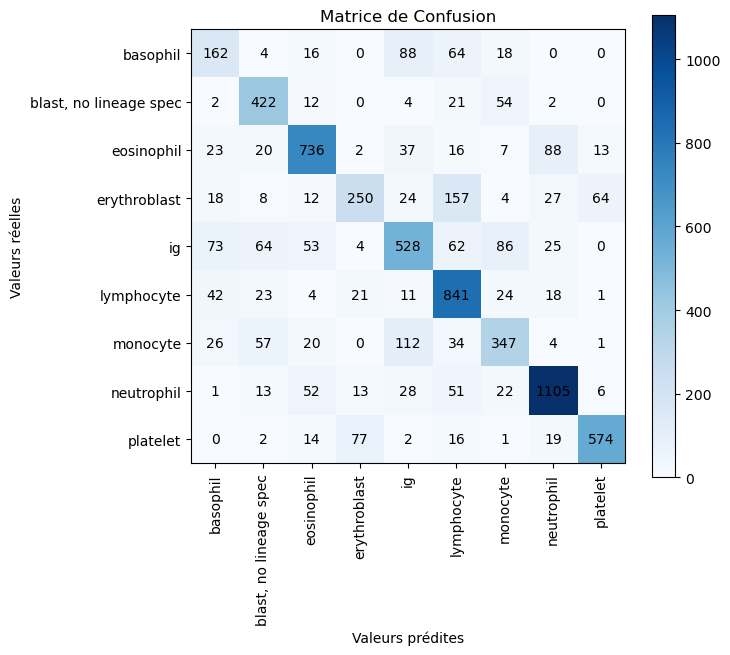

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Supposons que vous ayez déjà calculé votre matrice de confusion (confusion_mtx)
class_names = np.unique(y)
confusion_mtx=confusion_matrix(y_test, y_pred)
# Afficher la matrice de confusion avec Matplotlib imshow
plt.figure(figsize=(7, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap='Blues')
plt.title('Matrice de Confusion')
plt.colorbar()

# Définir les étiquettes des axes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

# Ajouter les valeurs dans les cellules
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(confusion_mtx[i, j]), ha='center', va='center')

plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()
